In [1]:
import pandas as pd
import json
from config import *
from ppp_prediction.utils import load_data
from ppp_prediction.model import fit_best_model
import pickle


import matplotlib.pyplot as plt
import seaborn as sns
from ppp_prediction.plot.utils import save_fig

params = {
    "axes.labelsize": 14,  # fontsize for x and y labels (was 10)
    "font.size": 8,  # was 10
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "text.usetex": False,
    "figure.figsize": [5, 5],
    "font.family": "Calibri",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 2,
    # set title fontsize
    "axes.titlesize": 15,
    "axes.titleweight": "bold",
    "figure.titlesize": 15,
    # label
    "axes.labelweight": "bold",
}

plt.rcParams.update(params)

%config InlineBackend.figure_format = "svg"
%config InlineBackend.print_figure_kwargs = {"dpi" : 300}



/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-02-17 10:11:36,014	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-17 10:11:36,279	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-17 10:11:36,400	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
diseaserawDir = dataDir / "label"



def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [3]:
Prot_train = load_data(dataDir / "imputeData" / "Prot_train.feather")
# held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
# held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
# print(RF_train.info())

# RF_train = load_data(dataDir / "imputeData" / "RF_train.feather")
# NMR_train = load_data(dataDir / "imputeData" / "NMR_train.feather")
held_out_train = load_data(dataDir / "imputeData" / "held_out_train.feather")
held_out_test = load_data(dataDir / "imputeData" / "held_out_test.feather")
print(Prot_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24144 entries, 0 to 24143
Columns: 2912 entries, eid to ZPR1
dtypes: float64(2911), object(1)
memory usage: 536.4+ MB
None


In [4]:



def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [5]:
drop_dict = {
    "T2D": ["Glucose", "glucose", "glycated_haemoglobin_hba1c"],
    "Stroke": None,
    "Heart_Failure": None,
    "Coronary_Artery_Disease": None,
    "Chronic_kidney_disease": ["Creatinine", "creatinine"],
    "Atrial_fibrillation_or_flutter": None,
    "PAD": None,
    "Hypertension": None,
    "Venous_Thromboembolism": None,
    "CMD": ["Creatinine", "creatinine", "Glucose", "glucose"],
}


def drop_value_from_list(l, v=None):
    if v is None:
        return l
    if len(v) == 0:
        return l
    will_drop = []
    will_keep = []
    for i in l:
        if i in v:
            will_drop.append(i)
        else:
            will_keep.append(i)
    print(f"will drop {will_drop}")
    return will_keep
    # will_drop.extend(drop_dict[i])

In [6]:
list(diseaserawDir.glob("*"))

[PosixPath('V4/data/label/Coronary_Artery_Disease.feather'),
 PosixPath('V4/data/label/Heart_Failure.feather'),
 PosixPath('V4/data/label/Hypertension.feather'),
 PosixPath('V4/data/label/Stroke.feather'),
 PosixPath('V4/data/label/Atrial_fibrillation_or_flutter.feather'),
 PosixPath('V4/data/label/Chronic_kidney_disease.feather'),
 PosixPath('V4/data/label/PAD.feather'),
 PosixPath('V4/data/label/Venous_Thromboembolism.feather'),
 PosixPath('V4/data/label/T2D.feather')]

In [7]:
from ppp_prediction.model_v2.models import (
    fit_best_model_v2,
    fit_ensemble_model_simple_v2,
    fit_lightgbm,
    fit_xgboost,
)

In [8]:
modelSaveDir = outputDir / "0x-tabpfn-Prot"

In [9]:

import numpy as np 
def get_sig_vars(tgt_dir = "V2/output/02-risk-model/02-Result/", tgt_name="NMR", suffix = "glmnet/bootstrap/bootstrap_coef_df.csv", topk=50):
    tgt_dir = Path(tgt_dir)
    all_disease = list(tgt_dir.glob("*"))

    res_dict = {}
    for disease in all_disease:
        disease_name = disease.name
        tgt_coef_file = tgt_dir / disease_name / tgt_name/ suffix
        if tgt_coef_file.exists():
            coef_df = pd.read_csv(tgt_coef_file)
            coef_df.set_index(coef_df.columns[0], inplace=True)
            coef_df = np.abs(coef_df.mean(axis=1)).sort_values(ascending=False)
            coef_df = coef_df[coef_df > 0].head(topk).index.tolist()

            res_dict[disease_name] = coef_df
    return res_dict
            
            
            
            
        
    
    

In [15]:
from collections import defaultdict
from ppp_prediction.cox import run_cox

# from ppp_prediction.model import run_glmnet
E = "incident"
T = "survTime"
disease_dict = defaultdict(dict)

for disease_dir in diseaserawDir.glob("*"):
    disease_name = disease_dir.stem


    disease_df = load_data(disease_dir)

    disease_train = disease_df.merge(Prot_train, on="eid", how="inner")
    disease_data_held_out_train = disease_df.merge(
        held_out_train, on="eid", how="inner"
    )
    disease_data_held_out_test = disease_df.merge(held_out_test, on="eid", how="inner")

    disease_modelSaveDir = modelSaveDir / disease_name
    disease_modelSaveDir.mkdir(parents=True, exist_ok=True)
    if (disease_modelSaveDir / "metrics.csv").exists():
        print(f"{disease_name} already exists")
        
        # c_disease_dict = pickle.load(
        #     open(disease_modelSaveDir / "disease_dict.pkl", "rb")
        # )
    else:
        final_need_cols = ["eid", "incident", "survTime", "date"]
        c_model_dict = {}

        # for name, combination in clinical_risk_dict.items():
        # name = "PANEL"
        # combination = clinical_risk_dict[name]
        combination = list(Prot_train.columns)[1:]
        

        # split data 

        # 1) full data ; 2) random sample data 
        n_case_train = int(disease_train["incident"].sum())
    
        disease_train = disease_train.dropna(subset=["incident", *combination])
        disease_train_case = disease_train.query("incident == 1").sample(n=5000 if n_case_train > 5000 else n_case_train)
        # disease_train_control = disease_train.query("incident == 0").sample(n=5000 if n_case_train > 5000 else n_case_train)
        disease_train_control = disease_train.query("incident == 0").sample(n=5000)


        # train model 
        # metrics_res = [] 
        score_name_list = ["lasso_full", "xgboost_full"]
        # basic_cols = ["eid", E, T, "incident", "survTime", "date"]
        
        disease_data_held_out_train = disease_data_held_out_train.dropna(
            subset=["incident", *combination]
        )
        X_held_out_train = disease_data_held_out_train[combination]
        y_held_out_train = disease_data_held_out_train["incident"]

        disease_data_held_out_test = disease_data_held_out_test.dropna(
            subset=["incident", *combination]
        )
        X_held_out_test = disease_data_held_out_test[combination]
        y_held_out_test = disease_data_held_out_test["incident"]
         


        # Test model 1) full lasso xgboost 2) sampled and features from 5, 10, 20, 50, 100, 200 of lasso, AutoTabPFN, xgboost

        # 1) Lasso full  
        lasso_full_savedir = disease_modelSaveDir / "lasso_full.pkl"
        if lasso_full_savedir.exists():
            lasso_full = pickle.load(open(lasso_full_savedir, "rb"))
            print(f"{disease_name} lasso_full loaded")
 
        else: 
            (lasso_full, *_) = fit_best_model(
                train_df=disease_train,
                test_df=disease_data_held_out_test,
                X_var=combination,
                y_var="incident",
                method_list="Lasso",
                cv=3,
                engine="cuml",
            )
                
            pickle.dump(
                lasso_full, open(lasso_full_savedir, "wb")
            )
        
        disease_data_held_out_test["lasso_full"] = get_predict_v2_from_df(
            lasso_full, disease_data_held_out_test, combination
        )

        del lasso_full

        # xgboost full 
        xgboot_full_savedir = disease_modelSaveDir / "xgboost_full.pkl"
        if (disease_modelSaveDir / "xgboost_full.pkl").exists():
            print(f"{disease_name} xgboost_full loaded")
            xgboost_full_tuned = pickle.load(open(xgboot_full_savedir, "rb"))
        else:
            
            xgboost_full_tuned, *_ = fit_xgboost(
                train = disease_train,
                xvar = combination,
                label = "incident",
                tuning = True,
                tune_config = {"max_iter": 100}
            )
            pickle.dump(
                xgboost_full_tuned, open(xgboot_full_savedir, "wb")
            )
        disease_data_held_out_test["xgboost_full"] = get_predict_v2_from_df(
            xgboost_full_tuned, disease_data_held_out_test, combination
        )

        del xgboost_full_tuned

        
        for topk in [5, 10, 20, 50, 100]:
            print(f"{disease_name} {topk}")
            combination_dict = get_sig_vars(tgt_name = "Prot", topk=topk)
            sig_combination = combination_dict[disease_name]
            disease_train_sample = pd.concat([disease_train_case, disease_train_control])[['eid', E, T ] + sig_combination]
            X_train = disease_train_sample[sig_combination]
            y_train = disease_train_sample["incident"]
            
            lasso_sample_topk_savedir = disease_modelSaveDir / f"lasso_sample_{topk}.pkl"
            if lasso_sample_topk_savedir.exists():
                lasso_sample = pickle.load(open(lasso_sample_topk_savedir, "rb"))
                print(f"{disease_name} lasso_sample_{topk} loaded")
            else:

                (lasso_sample, *_) = fit_best_model(
                    train_df=disease_train_sample,
                    test_df=disease_data_held_out_test,
                    X_var=sig_combination,
                    y_var="incident",
                    method_list="Lasso",
                    cv=3,
                    engine="cuml",
                )
                pickle.dump(
                lasso_sample, open(disease_modelSaveDir / f"lasso_sample_{topk}.pkl", "wb")
            )
            disease_data_held_out_test[f"lasso_sample_{topk}"] = get_predict_v2_from_df(
                            lasso_sample, disease_data_held_out_test, sig_combination
            )
 
            del lasso_sample
            
            from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
            
            AutoTabPFN_topk_savedir = disease_modelSaveDir / f"AutoTabPFN_{topk}.pkl"
            if AutoTabPFN_topk_savedir.exists():
                AutoTabPFN = pickle.load(open(AutoTabPFN_topk_savedir, "rb"))
                print(f"{disease_name} AutoTabPFN_{topk} loaded")
            else:


                AutoTabPFN = AutoTabPFNClassifier(max_time=120, device='cuda') # 120 seconds tuning time
                AutoTabPFN.fit(X_train, y_train)
                pickle.dump(
                AutoTabPFN, open(disease_modelSaveDir / f"AutoTabPFN_{topk}.pkl", "wb")
            )
            # disease_data_held_out_test["AutoTabPFN"] = AutoTabPFN.predict_proba(X_held_out_test)[:, 1]
            disease_data_held_out_test[f"AutoTabPFN_{topk}"] = AutoTabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]
    
            del AutoTabPFN


            # xgboost sampled
            xgboost_sample_savedir = disease_modelSaveDir / f"xgboost_sample_{topk}.pkl"
            if xgboost_sample_savedir.exists():
                xgboost_sample_tuned = pickle.load(open(xgboost_sample_savedir, "rb"))
                print(f"{disease_name} xgboost_sample_{topk} loaded")
            else:

                xgboost_sample_tuned, *_ = fit_xgboost(
                train = disease_train_sample,
                xvar = sig_combination,
                label= "incident",
                tuning= True,
                tune_config = {"max_iter": 100}
            )
                pickle.dump(
                xgboost_sample_tuned, open(disease_modelSaveDir / f"xgboost_sample_{topk}.pkl", "wb")
            )
            disease_data_held_out_test[f"xgboost_sample_{topk}"] = get_predict_v2_from_df(
                xgboost_sample_tuned, disease_data_held_out_test, sig_combination
            )

            del xgboost_sample_tuned
            score_name_list.extend([f"lasso_sample_{topk}", f"xgboost_sample_{topk}", f"AutoTabPFN_{topk}"])



        held_out_test_df_to_save = disease_data_held_out_test[["eid", "incident", "survTime", "date"] + score_name_list].reset_index(drop=True)
        held_out_test_df_to_save.to_feather(disease_modelSaveDir / "held_out_test.feather")
        from ppp_prediction.metrics import cal_binary_metrics
        metrics_list = [] 
        for key in score_name_list:
            to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
            res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
            # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
            res["disease"] = disease_name
            res["method"] = key
            metrics_list.append(res)
        metrics_df = pd.DataFrame(metrics_list)
        metrics_df.to_csv(disease_modelSaveDir / "metrics.csv", index=False)
         
        

Coronary_Artery_Disease already exists
[I] [16:50:48.009390] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['A1BG', 'AAMDC', 'AARSD1', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO', 'ABRAXAS2', 'ACAA1', 'ACADM', 'ACADSB', 'ACAN', 'ACE', 'ACE2', 'ACHE', 'ACOT13', 'ACOX1', 'ACP1', 'ACP5', 'ACP6', 'ACRBP', 'ACRV1', 'ACSL1', 'ACTA2', 'ACTN2', 'ACTN4', 'ACVRL1', 'ACY1', 'ACY3', 'ACYP1', 'ADA', 'ADA2', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAM8', 'ADAM9', 'ADAMTS1', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16', 'ADAMTS4', 'ADAMTS8', 'ADAMTSL2', 'ADAMTSL4', 'ADAMTSL5', 'ADCYAP1R1', 'ADD1', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRV1', 'ADH1B', 'ADH4', 'ADIPOQ', 'ADM', 'ADRA2A', 'AFAP1', 'AFM', 'AFP', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP', 'AGT', 'AGXT', 'AHCY', 'AHNAK', 'AHNAK2', 'AHSA1', 'AHSG', 'AHSP', 'AIDA', 'AIF1', 'AIF1L', 'AIFM1', 'AK1', 'AK2', 'AKAP12', 'AKR1B1', 'AKR1B10', 'AKR1C4', 'AKR7L', 'AK

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/api_decorators.py", line 188, in wrapper
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/api_decorators.py", line 393, in dispatch
    return self.dispatch_func(func_name, gpu_func, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/api_decorators.py", line 190, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "base.pyx", line 720, in cuml.internals.base.UniversalBase.dispatch_func
  File "elastic_net.pyx", line 261, in cuml.linear_model.elastic_net.ElasticNet.fit
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/api_decorators.py", line 188, in wrapper
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "cd.pyx", line 230, in cuml.solvers.cd.CD.fit
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/nvtx/nvtx.py", line 116, in inner
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/input_utils.py", line 412, in input_to_cuml_array
    arr = CumlArray.from_input(
          ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/memory_utils.py", line 87, in cupy_rmm_wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/nvtx/nvtx.py", line 116, in inner
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/array.py", line 1169, in from_input
    arr.to_output(
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/memory_utils.py", line 87, in cupy_rmm_wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/nvtx/nvtx.py", line 116, in inner
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cuml/internals/array.py", line 647, in to_output
    return output_mem_type.xpy.asarray(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/cupy/_creation/from_data.py", line 88, in asarray
    return _core.array(a, dtype, False, order, blocking=blocking)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "cupy/_core/core.pyx", line 2408, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2435, in cupy._core.core.array
  File "cupy/_core/core.pyx", line 2578, in cupy._core.core._array_default
  File "cupy/_core/core.pyx", line 137, in cupy._core.core.ndarray.__new__
  File "cupy/_core/core.pyx", line 225, in cupy._core.core._ndarray_base._init
  File "cupy/cuda/memory.pyx", line 738, in cupy.cuda.memory.alloc
  File "/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/rmm/allocators/cupy.py", line 37, in rmm_cupy_allocator
    buf = pylibrmm.device_buffer.DeviceBuffer(size=nbytes, stream=stream)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "device_buffer.pyx", line 103, in rmm.pylibrmm.device_buffer.DeviceBuffer.__cinit__
MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /tmp/pip-build-env-m_qegmhe/normal/lib/python3.11/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory


In [12]:
held_out_test_df_to_save = disease_data_held_out_test[["eid", "incident", "survTime", "date"] + score_name_list].reset_index(drop=True)
held_out_test_df_to_save.to_feather(disease_modelSaveDir / "held_out_test.feather")
from ppp_prediction.metrics import cal_binary_metrics
metrics_list = [] 
for key in score_name_list:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key
    metrics_list.append(res)
metrics_df = pd.DataFrame(metrics_list)
# metrics_df.to_csv(disease_modelSaveDir / "metrics.csv", index=False)
# break 

In [14]:
metrics_df.to_csv(disease_modelSaveDir / "metrics.csv", index=False)

In [ ]:
from tabpfn import TabPFNClassifier


# Initialize a classifier
TabPFN = TabPFNClassifier(device='cuda:0', ignore_pretraining_limits=True)
TabPFN.fit(X_train, y_train)
disease_data_held_out_test["TabPFN"] = TabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]


In [ ]:
# disease_data_held_out_test["TabPFN"] = TabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]


In [ ]:
X_train.shape

In [ ]:
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier


# Initialize a classifier
AutoTabPFN = AutoTabPFNClassifier(max_time=120, device='cuda') # 120 seconds tuning time
AutoTabPFN.fit(X_train, y_train)
disease_data_held_out_test["AutoTabPFN"] = AutoTabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]


In [ ]:
disease_data_held_out_test["AutoTabPFN"] = AutoTabPFN.predict_proba(disease_data_held_out_test[sig_combination])[:, 1]


In [ ]:
(lasso_sample, *_) = fit_best_model(
               train_df=disease_train_sample,
    test_df=disease_data_held_out_test,
    X_var=sig_combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)
disease_data_held_out_test["lasso_sample"] = get_predict_v2_from_df(
    lasso_sample, disease_data_held_out_test, sig_combination
)


In [68]:
# (lasso_full, *_) = fit_best_model(
#     train_df=disease_train,
#     test_df=disease_data_held_out_test,
#     X_var=combination,
#     y_var="incident",
#     method_list="Lasso",
#     cv=3,
#     engine="cuml",
# )
# disease_data_held_out_test["lasso_full"] = get_predict_v2_from_df(
#     lasso_full, disease_data_held_out_test, sig_combination
# )




In [70]:
from ppp_prediction.metrics import cal_binary_metrics

metrics_list = [] 
for key in [ "TabPFN", "AutoTabPFN",  "lasso_sample"]:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key
    metrics_list.append(res)
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method
0,0.733439,0.747037,0.718064,0.568120,0.574704,0.559321,0.465208,0.470651,0.456885,0.789661,...,0.555081,0.537724,0.203363,0.217200,0.180796,13689,1122.0,12567.0,Coronary_Artery_Disease,TabPFN
1,0.736563,0.748754,0.726292,0.664986,0.671411,0.654940,0.516786,0.525537,0.507222,0.678253,...,0.670466,0.654742,0.196130,0.212863,0.181170,13689,1122.0,12567.0,Coronary_Artery_Disease,AutoTabPFN
2,0.708839,0.719869,0.695107,0.675360,0.684276,0.669183,0.517916,0.524418,0.513226,0.633690,...,0.686270,0.670682,0.179379,0.193195,0.160902,13689,1122.0,12567.0,Coronary_Artery_Disease,lasso_sample


In [21]:
disease_name

'T2D'

In [33]:
from ppp_prediction.metrics import cal_binary_metrics
for key in [ "AutoTabPFN"]:
    to_cal_df = disease_data_held_out_test[["eid", E, T, key]].copy().dropna()
    res = cal_binary_metrics(to_cal_df["incident"], to_cal_df[key], n_resamples= 30, ci = True)
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["disease"] = disease_name
    res["method"] = key

In [64]:
del AutoTabPFN

In [18]:
(lasso_full, *_) = fit_best_model(
    train_df=disease_train,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)
(lasso_sample, *_) = fit_best_model(
               train_df=disease_train_sample,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)



[I] [14:47:35.243368] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['A1BG', 'AAMDC', 'AARSD1', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO', 'ABRAXAS2', 'ACAA1', 'ACADM', 'ACADSB', 'ACAN', 'ACE', 'ACE2', 'ACHE', 'ACOT13', 'ACOX1', 'ACP1', 'ACP5', 'ACP6', 'ACRBP', 'ACRV1', 'ACSL1', 'ACTA2', 'ACTN2', 'ACTN4', 'ACVRL1', 'ACY1', 'ACY3', 'ACYP1', 'ADA', 'ADA2', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAM8', 'ADAM9', 'ADAMTS1', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16', 'ADAMTS4', 'ADAMTS8', 'ADAMTSL2', 'ADAMTSL4', 'ADAMTSL5', 'ADCYAP1R1', 'ADD1', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRV1', 'ADH1B', 'ADH4', 'ADIPOQ', 'ADM', 'ADRA2A', 'AFAP1', 'AFM', 'AFP', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP', 'AGT', 'AGXT', 'AHCY', 'AHNAK', 'AHNAK2', 'AHSA1', 'AHSG', 'AHSP', 'AIDA', 'AIF1', 'AIF1L', 'AIFM1', 'AK1', 'AK2', 'AKAP12', 'AKR1B1', 'AKR1B10', 'AKR1C4', 'AKR7L', 'AKT1S1', 'AKT2', 'AKT3', 'ALCAM', 'ALDH1A

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


model: Lasso	Best parameters: {'model__alpha': 0.003593813663804626}, with auc: 0.8827768123480434


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


In [19]:
(lasso_sample, *_) = fit_best_model(
               train_df=disease_train_sample,
    test_df=disease_data_held_out_test,
    X_var=combination,
    y_var="incident",
    method_list="Lasso",
    cv=3,
    engine="cuml",
)


[I] [14:50:28.640153] Unused keyword parameter: random_state during cuML estimator initialization
y_var: incident, X_var: ['A1BG', 'AAMDC', 'AARSD1', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO', 'ABRAXAS2', 'ACAA1', 'ACADM', 'ACADSB', 'ACAN', 'ACE', 'ACE2', 'ACHE', 'ACOT13', 'ACOX1', 'ACP1', 'ACP5', 'ACP6', 'ACRBP', 'ACRV1', 'ACSL1', 'ACTA2', 'ACTN2', 'ACTN4', 'ACVRL1', 'ACY1', 'ACY3', 'ACYP1', 'ADA', 'ADA2', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAM8', 'ADAM9', 'ADAMTS1', 'ADAMTS13', 'ADAMTS15', 'ADAMTS16', 'ADAMTS4', 'ADAMTS8', 'ADAMTSL2', 'ADAMTSL4', 'ADAMTSL5', 'ADCYAP1R1', 'ADD1', 'ADGRB3', 'ADGRD1', 'ADGRE1', 'ADGRE2', 'ADGRE5', 'ADGRF5', 'ADGRG1', 'ADGRG2', 'ADGRV1', 'ADH1B', 'ADH4', 'ADIPOQ', 'ADM', 'ADRA2A', 'AFAP1', 'AFM', 'AFP', 'AGBL2', 'AGER', 'AGR2', 'AGR3', 'AGRN', 'AGRP', 'AGT', 'AGXT', 'AHCY', 'AHNAK', 'AHNAK2', 'AHSA1', 'AHSG', 'AHSP', 'AIDA', 'AIF1', 'AIF1L', 'AIFM1', 'AK1', 'AK2', 'AKAP12', 'AKR1B1', 'AKR1B10', 'AKR1C4', 'AKR7L', 'AKT1S1', 'AKT2', 'AKT3', 'ALCAM', 'ALDH1A

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y

model: Lasso	Best parameters: {'model__alpha': 1e-06}, with auc: 0.7932253628242563


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


## compare

In [9]:
import pandas as pd
from pathlib import Path



In [10]:
res_df = pd.concat([pd.read_csv(i) for i in list(modelSaveDir.rglob("metrics.csv"))])
res_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method
0,0.843460,0.870267,0.823132,0.860999,0.866025,0.855568,0.534397,0.539083,0.523825,0.684874,...,0.871316,0.858530,0.198033,0.240092,0.149438,13892,238.0,13654.0,Heart_Failure,lasso_full
1,0.779304,0.812526,0.755626,0.785056,0.793142,0.779380,0.487135,0.493143,0.482008,0.668067,...,0.793209,0.780689,0.152057,0.201771,0.115488,13892,238.0,13654.0,Heart_Failure,xgboost_full
2,0.775239,0.801982,0.752004,0.808091,0.816358,0.802138,0.496563,0.505534,0.490770,0.626050,...,0.817071,0.805471,0.072713,0.083423,0.053270,13892,238.0,13654.0,Heart_Failure,lasso_sample_5
3,0.766013,0.804242,0.727671,0.780233,0.786084,0.774798,0.482786,0.487799,0.475405,0.638655,...,0.788022,0.776583,0.081291,0.099757,0.059426,13892,238.0,13654.0,Heart_Failure,xgboost_sample_5
4,0.776615,0.803075,0.758034,0.806795,0.812385,0.799196,0.495858,0.505498,0.489332,0.626050,...,0.814008,0.804050,0.073960,0.087839,0.048502,13892,238.0,13654.0,Heart_Failure,AutoTabPFN_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.604757,0.654480,0.569435,0.653248,0.660459,0.645992,0.416323,0.420293,0.413195,0.525581,...,0.661441,0.645952,0.023281,0.026938,0.017819,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_50
13,0.639886,0.679074,0.600433,0.566381,0.572461,0.560953,0.381276,0.385256,0.377400,0.632558,...,0.573773,0.557421,0.026660,0.033428,0.019058,14010,215.0,13795.0,Venous_Thromboembolism,AutoTabPFN_50
14,0.641813,0.673757,0.620616,0.398501,0.405079,0.393665,0.300976,0.306658,0.295029,0.813953,...,0.400120,0.383226,0.026497,0.032612,0.020028,14010,215.0,13795.0,Venous_Thromboembolism,lasso_sample_100
15,0.613845,0.655891,0.588271,0.745468,0.752154,0.738801,0.450573,0.455346,0.443072,0.418605,...,0.756749,0.743831,0.025668,0.030340,0.015786,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_100


In [21]:
res_df['ratio'] = res_df['method'].apply(lambda x: x.split("_")[-1] if "full" not in x else "full")
res_df['ratio'] = pd.Categorical(res_df['ratio'], categories=[ "5", "10", "20", "50", "100", "full"], ordered=True)
res_df['base_method'] = res_df['method'].apply(lambda x: x.split("_")[0])
res_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,APR,APR_UCI,APR_LCI,N,N_case,N_control,disease,method,ratio,base_method
0,0.843460,0.870267,0.823132,0.860999,0.866025,0.855568,0.534397,0.539083,0.523825,0.684874,...,0.198033,0.240092,0.149438,13892,238.0,13654.0,Heart_Failure,lasso_full,full,lasso
1,0.779304,0.812526,0.755626,0.785056,0.793142,0.779380,0.487135,0.493143,0.482008,0.668067,...,0.152057,0.201771,0.115488,13892,238.0,13654.0,Heart_Failure,xgboost_full,full,xgboost
2,0.775239,0.801982,0.752004,0.808091,0.816358,0.802138,0.496563,0.505534,0.490770,0.626050,...,0.072713,0.083423,0.053270,13892,238.0,13654.0,Heart_Failure,lasso_sample_5,5,lasso
3,0.766013,0.804242,0.727671,0.780233,0.786084,0.774798,0.482786,0.487799,0.475405,0.638655,...,0.081291,0.099757,0.059426,13892,238.0,13654.0,Heart_Failure,xgboost_sample_5,5,xgboost
4,0.776615,0.803075,0.758034,0.806795,0.812385,0.799196,0.495858,0.505498,0.489332,0.626050,...,0.073960,0.087839,0.048502,13892,238.0,13654.0,Heart_Failure,AutoTabPFN_5,5,AutoTabPFN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,0.604757,0.654480,0.569435,0.653248,0.660459,0.645992,0.416323,0.420293,0.413195,0.525581,...,0.023281,0.026938,0.017819,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_50,50,xgboost
13,0.639886,0.679074,0.600433,0.566381,0.572461,0.560953,0.381276,0.385256,0.377400,0.632558,...,0.026660,0.033428,0.019058,14010,215.0,13795.0,Venous_Thromboembolism,AutoTabPFN_50,50,AutoTabPFN
14,0.641813,0.673757,0.620616,0.398501,0.405079,0.393665,0.300976,0.306658,0.295029,0.813953,...,0.026497,0.032612,0.020028,14010,215.0,13795.0,Venous_Thromboembolism,lasso_sample_100,100,lasso
15,0.613845,0.655891,0.588271,0.745468,0.752154,0.738801,0.450573,0.455346,0.443072,0.418605,...,0.025668,0.030340,0.015786,14010,215.0,13795.0,Venous_Thromboembolism,xgboost_sample_100,100,xgboost


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


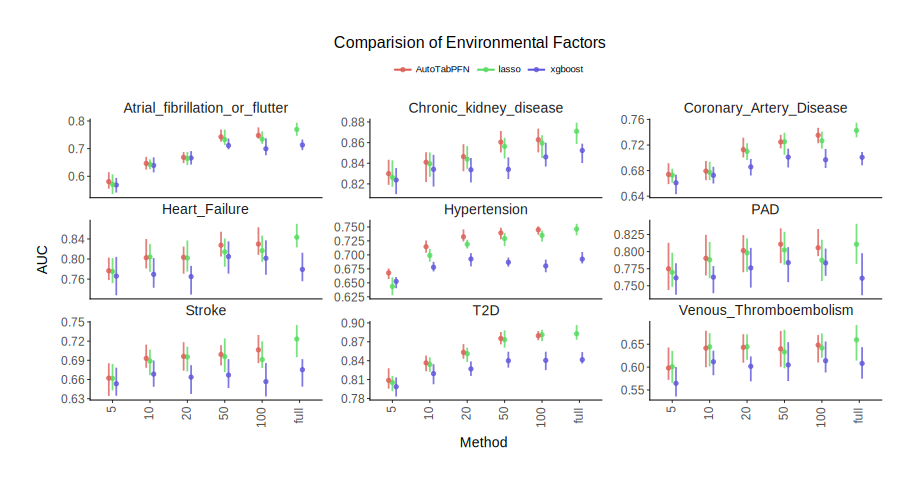

In [29]:
from plotnine import * 
p = (
    ggplot(
        data=res_df,
        mapping=aes(x="ratio", y="AUC", color="base_method"),
    )
    + facet_wrap("disease", scales="free_y")
    + geom_line(
        size=1,
        # color="black",
        # mapping = aes(="method"),
    )
    + geom_point(alpha=0.8, size=2, position=position_dodge(width=0.3), na_rm=True)
    # + geom_jitter(width=0.1, height=0.1)
    + geom_linerange(
        mapping=aes(ymin="AUC_LCI", ymax="AUC_UCI"),
        size=1,
        alpha=0.8,
        position=position_dodge(width=0.3),
        na_rm=True,
    )
    + theme_classic( base_size=12)  # 使用Tufte主题
    + theme(axis_line=element_line())
    + theme(
        figure_size=(12, 6),
        legend_position="top",
        axis_text_x=element_text(angle=90),
        strip_background=element_blank(),
        axis_text=element_text(size=12),  # 调整轴文字大小
        axis_title=element_text(size=14),  # 调整轴标题大小和样式
        legend_title=element_text(size=14),  # 调整图例标题大小和样式
        legend_text=element_text(),  # 调整图例文字大小
        strip_text=element_text(size=14),  # 调整分面标签的大小和样式
        plot_title=element_text(size=16, hjust=0.5),  # 添加图表标题并居中
        # plot_margin = margin(10, 10, 10, 10)  # 设置图表边距
    )
    + guides(color=guide_legend(nrow=1, title=""))

    + labs(
        x="Method",  # 设置X轴标签
        y="AUC",  # 设置Y轴标签
        # color="group",  # 设置图例标题
        title="Comparision of Environmental Factors",  # 添加图表标题
    )
)

p

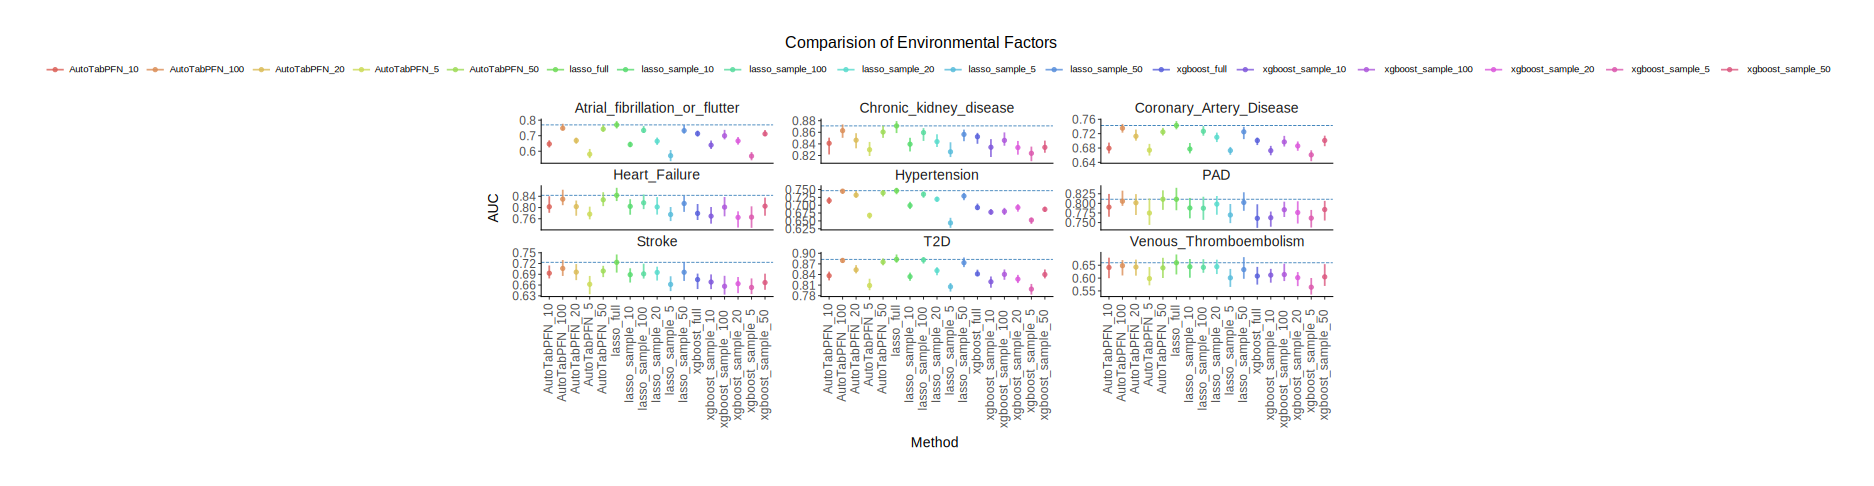

In [15]:
from plotnine import * 
p = (
    ggplot(
        data=res_df,
        mapping=aes(x="method", y="AUC", color="method"),
    )
    + facet_wrap("disease", scales="free_y")
    + geom_hline(
        data=res_df.query("method == 'AutoTabPFN'"),
        mapping=aes(yintercept="AUC"),
        linetype="dashed",  # shixian
        color="#bebebe",
    )
    + geom_hline(
        data=res_df.query("method == 'lasso_full'"),
        mapping=aes(yintercept="AUC"),
        linetype="dashed",
        color="#377eb8",
    )
    # + geom_hline(
    #     yintercept=0.5,
    #     linetype="dashed",
    #     color="black",
    # )
    + geom_point(alpha=0.8, size=2, position=position_dodge(width=0.3), na_rm=True)
    # + geom_jitter(width=0.1, height=0.1)
    + geom_linerange(
        mapping=aes(ymin="AUC_LCI", ymax="AUC_UCI"),
        size=1,
        alpha=0.8,
        position=position_dodge(width=0.3),
        na_rm=True,
    )
    + theme_classic( base_size=12)  # 使用Tufte主题
    + theme(axis_line=element_line())
    + theme(
        figure_size=(12, 6),
        legend_position="top",
        axis_text_x=element_text(angle=90),
        strip_background=element_blank(),
        axis_text=element_text(size=12),  # 调整轴文字大小
        axis_title=element_text(size=14),  # 调整轴标题大小和样式
        legend_title=element_text(size=14),  # 调整图例标题大小和样式
        legend_text=element_text(),  # 调整图例文字大小
        strip_text=element_text(size=14),  # 调整分面标签的大小和样式
        plot_title=element_text(size=16, hjust=0.5),  # 添加图表标题并居中
        # plot_margin = margin(10, 10, 10, 10)  # 设置图表边距
    )
    + guides(color=guide_legend(nrow=1, title=""))
    # + scale_color_manual(
    #     values=color_dict,
    # )
    + labs(
        x="Method",  # 设置X轴标签
        y="AUC",  # 设置Y轴标签
        # color="group",  # 设置图例标题
        title="Comparision of Environmental Factors",  # 添加图表标题
    )
    # + coord_flip()
)
# print(p)
p